In [57]:
# Importing libraries
import os, shutil, random
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory path
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'

In [3]:
# Configs for image Generator
target_size = (224, 224)
train_batch = 4710
test_batch = 522
val_batch = 624

In [4]:
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     test_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
class_weights = class_weight.compute_class_weight(
               class_weight = 'balanced',
               classes = np.unique(train_generator.classes), 
               y = train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9382716049382716, 1: 0.6738197424892703}

In [7]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
# Reshaping images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [9]:
import numpy as np
train_y = np.reshape(train_labels[:,0], (4710,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (522,1))

Looking at the above images, it's hard to infer much to an untrained eye. The images look very similar to each other.

The x-rays also all look pretty standard in terms of rotation and angle -- that means we probably don't need to worry about generating additional training images.

### Data Distribution

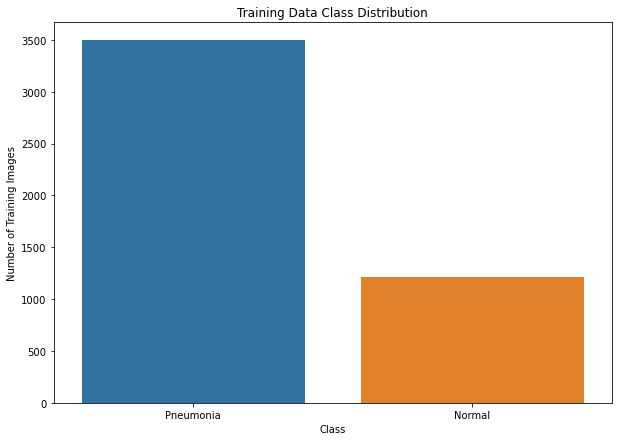

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.barplot(y=[sum(train_y==0)[0], sum(train_y==1)[0]],
            x=['Pneumonia', 'Normal'],
           orient ='v')
plt.title('Training Data Class Distribution')
plt.ylabel('Number of Training Images')
plt.xlabel('Class')
plt.show()

### Baseline model

In [11]:
from keras.layers import merge, Input
image_input = Input(shape=(224, 224, 3))

In [79]:
# Build a baseline fully connected model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

baseline_model = Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(150528,))) # 2 hidden layers
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                3010580   
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 3,010,735
Trainable params: 3,010,735
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Compile the image
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history = baseline_model.fit(train_img,
                    train_y,
                    class_weight=class_weights,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
148/148 [==============================] - 4s 24ms/step - loss: 0.6512 - acc: 0.7420 - val_loss: 0.3853 - val_acc: 0.7433
Epoch 2/20
148/148 [==============================] - 3s 23ms/step - loss: 0.3650 - acc: 0.8166 - val_loss: 0.2824 - val_acc: 0.8985
Epoch 3/20
148/148 [==============================] - 3s 24ms/step - loss: 0.3210 - acc: 0.8563 - val_loss: 0.3088 - val_acc: 0.8621
Epoch 4/20
148/148 [==============================] - 3s 23ms/step - loss: 0.2568 - acc: 0.8902 - val_loss: 0.3794 - val_acc: 0.8429
Epoch 5/20
148/148 [==============================] - 3s 23ms/step - loss: 0.2541 - acc: 0.9006 - val_loss: 0.3015 - val_acc: 0.8793
Epoch 6/20
148/148 [==============================] - 4s 24ms/step - loss: 0.2336 - acc: 0.9138 - val_loss: 0.6061 - val_acc: 0.5632
Epoch 7/20
148/148 [==============================] - 4s 24ms/step - loss: 0.2258 - acc: 0.9146 - val_loss: 1.2171 - val_acc: 0.7548
Epoch 8/20
148/148 [==============================] - 4s 24ms/step - 

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def evaluate_results(model, x, y):
    if y.shape[1] == 1:
        y_hat_test = model.predict(x)
        thresh = 0.5
        y_pred = (y_hat_test > thresh).astype(np.int)
        y_true = y.astype(np.int)
    else:
        y_pred  = []
        y_true = []
        for element in model.predict(x):
            highest_odds = max(element)
            ind_get = np.where(element == highest_odds)
            ind = ind_get[0][0]
            if ind == 0:
                y_pred.append(0)
            else:
                y_pred.append(1)
        for element in y:
            highest_odds = max(element)
            ind_get = np.where(element == highest_odds)
            ind = ind_get[0][0]
            if ind == 0:
                y_true.append(0)
            else:
                y_true.append(1)  
    #labels = ['NORMAL', 'PNEUMONIA']
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm
                                  #display_labels=labels
                                 )
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred)
    print('F1 score: %f' % f1)

In [16]:
def visualize_training_results(results):
    history = results.history
    keys = history.keys()
    plt.figure()
    legend = []
    for key in keys:
        if 'acc' in key:
            plt.plot(history[key])
            legend.append(key)
    plt.legend(legend)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    
    legend = []
    for key in keys:
        if 'loss' in key:
            plt.plot(history[key])
            legend.append(key)
    plt.legend(legend)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 

17/17 [==============================] - 0s 7ms/step


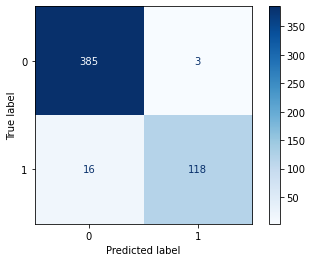

Accuracy: 0.963602
Precision: 0.975207
Recall: 0.880597
F1 score: 0.925490


In [81]:
evaluate_results(baseline_model, val_img, val_y)

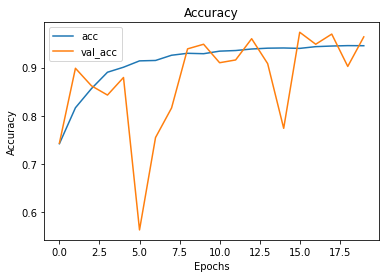

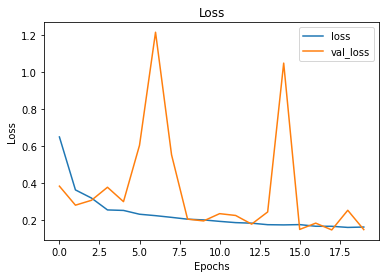

In [82]:
visualize_training_results(history)

Our baseline model is doing quite poorly. It's only predicting the dominant class all the time.

### Iteration 1 - Increasing Model Complexity

In [19]:
iter_1_model = Sequential()
iter_1_model.add(layers.Dense(20, activation='relu', input_shape=(150528,)))
iter_1_model.add(layers.Dense(15, activation='relu'))
iter_1_model.add(layers.Dense(10, activation='relu'))
iter_1_model.add(layers.Dense(7, activation='relu'))
iter_1_model.add(layers.Dense(5, activation='relu'))
iter_1_model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
iter_1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                3010580   
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 7)                 77        
                                                                 
 dense_7 (Dense)             (None, 5)                 40        
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,011,178
Trainable params: 3,011,178
No

In [21]:
# Compile the image
iter_1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

# Define callbacks

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

iter_1_checkpoint_filepath = 'models/iter_1_model.h5'
# iter_1_checkpoint_callback = ModelCheckpoint(
#     filepath=iter_1_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.00001)

# iter_1_hist = iter_1_model.fit(train_img,
#                     train_y,
#                     class_weight=class_weights,
#                     epochs=60,
#                     batch_size=32,
#                     callbacks=[iter_1_checkpoint_callback, reduce_lr],
#                     validation_data=(val_img, val_y))

Epoch 1/60
148/148 [==============================] - 2s 12ms/step - loss: 0.4667 - acc: 0.7420 - val_loss: 0.3252 - val_acc: 0.8391 - lr: 0.0100
Epoch 2/60
148/148 [==============================] - 2s 11ms/step - loss: 0.3403 - acc: 0.8280 - val_loss: 0.6239 - val_acc: 0.7510 - lr: 0.0100
Epoch 3/60
148/148 [==============================] - 2s 11ms/step - loss: 0.2896 - acc: 0.8601 - val_loss: 0.6265 - val_acc: 0.7739 - lr: 0.0100
Epoch 4/60
148/148 [==============================] - 2s 12ms/step - loss: 0.2693 - acc: 0.8790 - val_loss: 0.2318 - val_acc: 0.9425 - lr: 0.0100
Epoch 5/60
148/148 [==============================] - 2s 11ms/step - loss: 0.2430 - acc: 0.9004 - val_loss: 0.2164 - val_acc: 0.9502 - lr: 0.0100
Epoch 6/60
148/148 [==============================] - 2s 11ms/step - loss: 0.2280 - acc: 0.9070 - val_loss: 0.2110 - val_acc: 0.9464 - lr: 0.0100
Epoch 7/60
148/148 [==============================] - 2s 12ms/step - loss: 0.2196 - acc: 0.9183 - val_loss: 0.2059 - val_acc

148/148 [==============================] - 2s 11ms/step - loss: 0.1100 - acc: 0.9616 - val_loss: 0.1044 - val_acc: 0.9751 - lr: 1.0000e-05
Epoch 57/60
148/148 [==============================] - 2s 11ms/step - loss: 0.1100 - acc: 0.9616 - val_loss: 0.1045 - val_acc: 0.9751 - lr: 1.0000e-05
Epoch 58/60
148/148 [==============================] - 2s 11ms/step - loss: 0.1100 - acc: 0.9616 - val_loss: 0.1044 - val_acc: 0.9751 - lr: 1.0000e-05
Epoch 59/60
148/148 [==============================] - 2s 11ms/step - loss: 0.1100 - acc: 0.9614 - val_loss: 0.1043 - val_acc: 0.9751 - lr: 1.0000e-05
Epoch 60/60
148/148 [==============================] - 2s 11ms/step - loss: 0.1100 - acc: 0.9618 - val_loss: 0.1043 - val_acc: 0.9751 - lr: 1.0000e-05


17/17 [==============================] - 0s 4ms/step


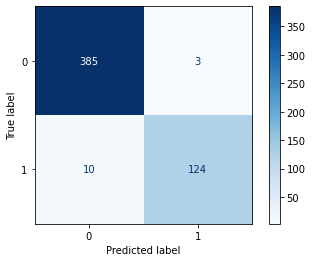

Accuracy: 0.975096
Precision: 0.976378
Recall: 0.925373
F1 score: 0.950192


In [22]:
evaluate_results(iter_1_model, val_img, val_y)

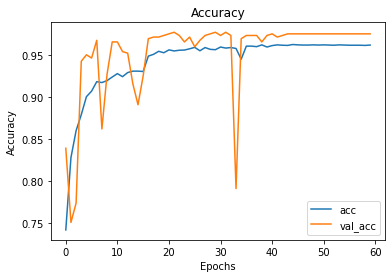

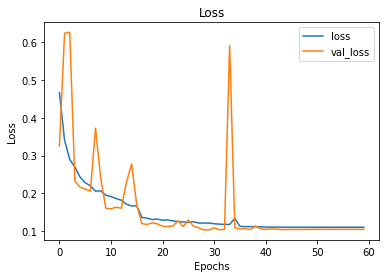

In [23]:
visualize_training_results(iter_1_hist)

This is better, but now this model is starting to miss penumonia cases. It mislabeled 15 cases.

### CNN
Convolutional Neural Networks (CNNs) are an algorithm well-suited for image processing tasks. They pass filters over an image and assign importance to different feature images for classification. This can make them well-suited for the task at hand, as we're trying to detect Pneumonia.

In [24]:
#Build the first CNN model
from tensorflow.keras import models

first_cnn_model = models.Sequential()

first_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Flatten())
first_cnn_model.add(layers.Dense(64, activation='relu'))
first_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
# Compile
# first_cnn_model.compile(loss='binary_crossentropy',
#               optimizer="sgd",
#               metrics=['acc'])

In [26]:
first_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

In [27]:
# Fit the model
tf.config.run_functions_eagerly(True)

first_cnn_checkpoint_filepath = 'models/first_cnn_model.h5'

# first_cnn_checkpoint_callback = ModelCheckpoint(
#     filepath=first_cnn_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# first_cnn_hist = first_cnn_model.fit(train_images,
#                     train_y,
#                     class_weight=class_weights,
#                     epochs=50,
#                     batch_size=32,
#                     callbacks=[first_cnn_checkpoint_callback, reduce_lr],
#                     validation_data=(val_images, val_y))

Epoch 1/50
148/148 [==============================] - 143s 965ms/step - loss: 0.5334 - acc: 0.7427 - val_loss: 0.3819 - val_acc: 0.8678 - lr: 0.0100
Epoch 2/50
148/148 [==============================] - 143s 965ms/step - loss: 0.3804 - acc: 0.8217 - val_loss: 0.3379 - val_acc: 0.8238 - lr: 0.0100
Epoch 3/50
148/148 [==============================] - 133s 897ms/step - loss: 0.2648 - acc: 0.8826 - val_loss: 1.5682 - val_acc: 0.7452 - lr: 0.0100
Epoch 4/50
148/148 [==============================] - 133s 896ms/step - loss: 0.2275 - acc: 0.8987 - val_loss: 0.1826 - val_acc: 0.9368 - lr: 0.0100
Epoch 5/50
148/148 [==============================] - 131s 888ms/step - loss: 0.1744 - acc: 0.9265 - val_loss: 0.1863 - val_acc: 0.9195 - lr: 0.0100
Epoch 6/50
148/148 [==============================] - 134s 903ms/step - loss: 0.1578 - acc: 0.9325 - val_loss: 0.1037 - val_acc: 0.9559 - lr: 0.0100
Epoch 7/50
148/148 [==============================] - 131s 885ms/step - loss: 0.1519 - acc: 0.9397 - val_l

17/17 [==============================] - 3s 195ms/step


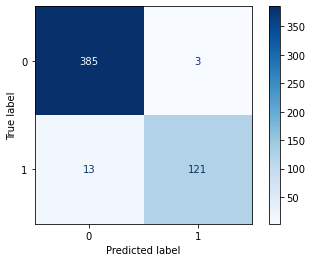

Accuracy: 0.969349
Precision: 0.975806
Recall: 0.902985
F1 score: 0.937984


In [28]:
evaluate_results(first_cnn_model, val_images, val_y)

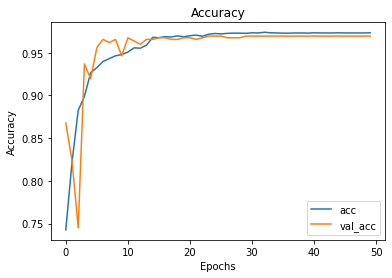

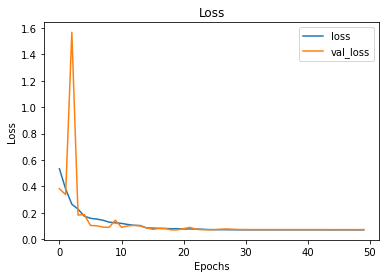

In [29]:
visualize_training_results(first_cnn_hist)

### Histogram Equalization
Histogram Equalization increases contrast in images by detecting the distribution of pixel densities in an image and plotting these pixel densities on a histogram.

[Research](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949) published in 2022 showed that using Histogram Equalization led to improved performence of CNNs in image classification tasks for Pneumonia and COVID-19. We will try to implementat those here.

To implement this using ImageDataGenerator, we will follow [this guide](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085).

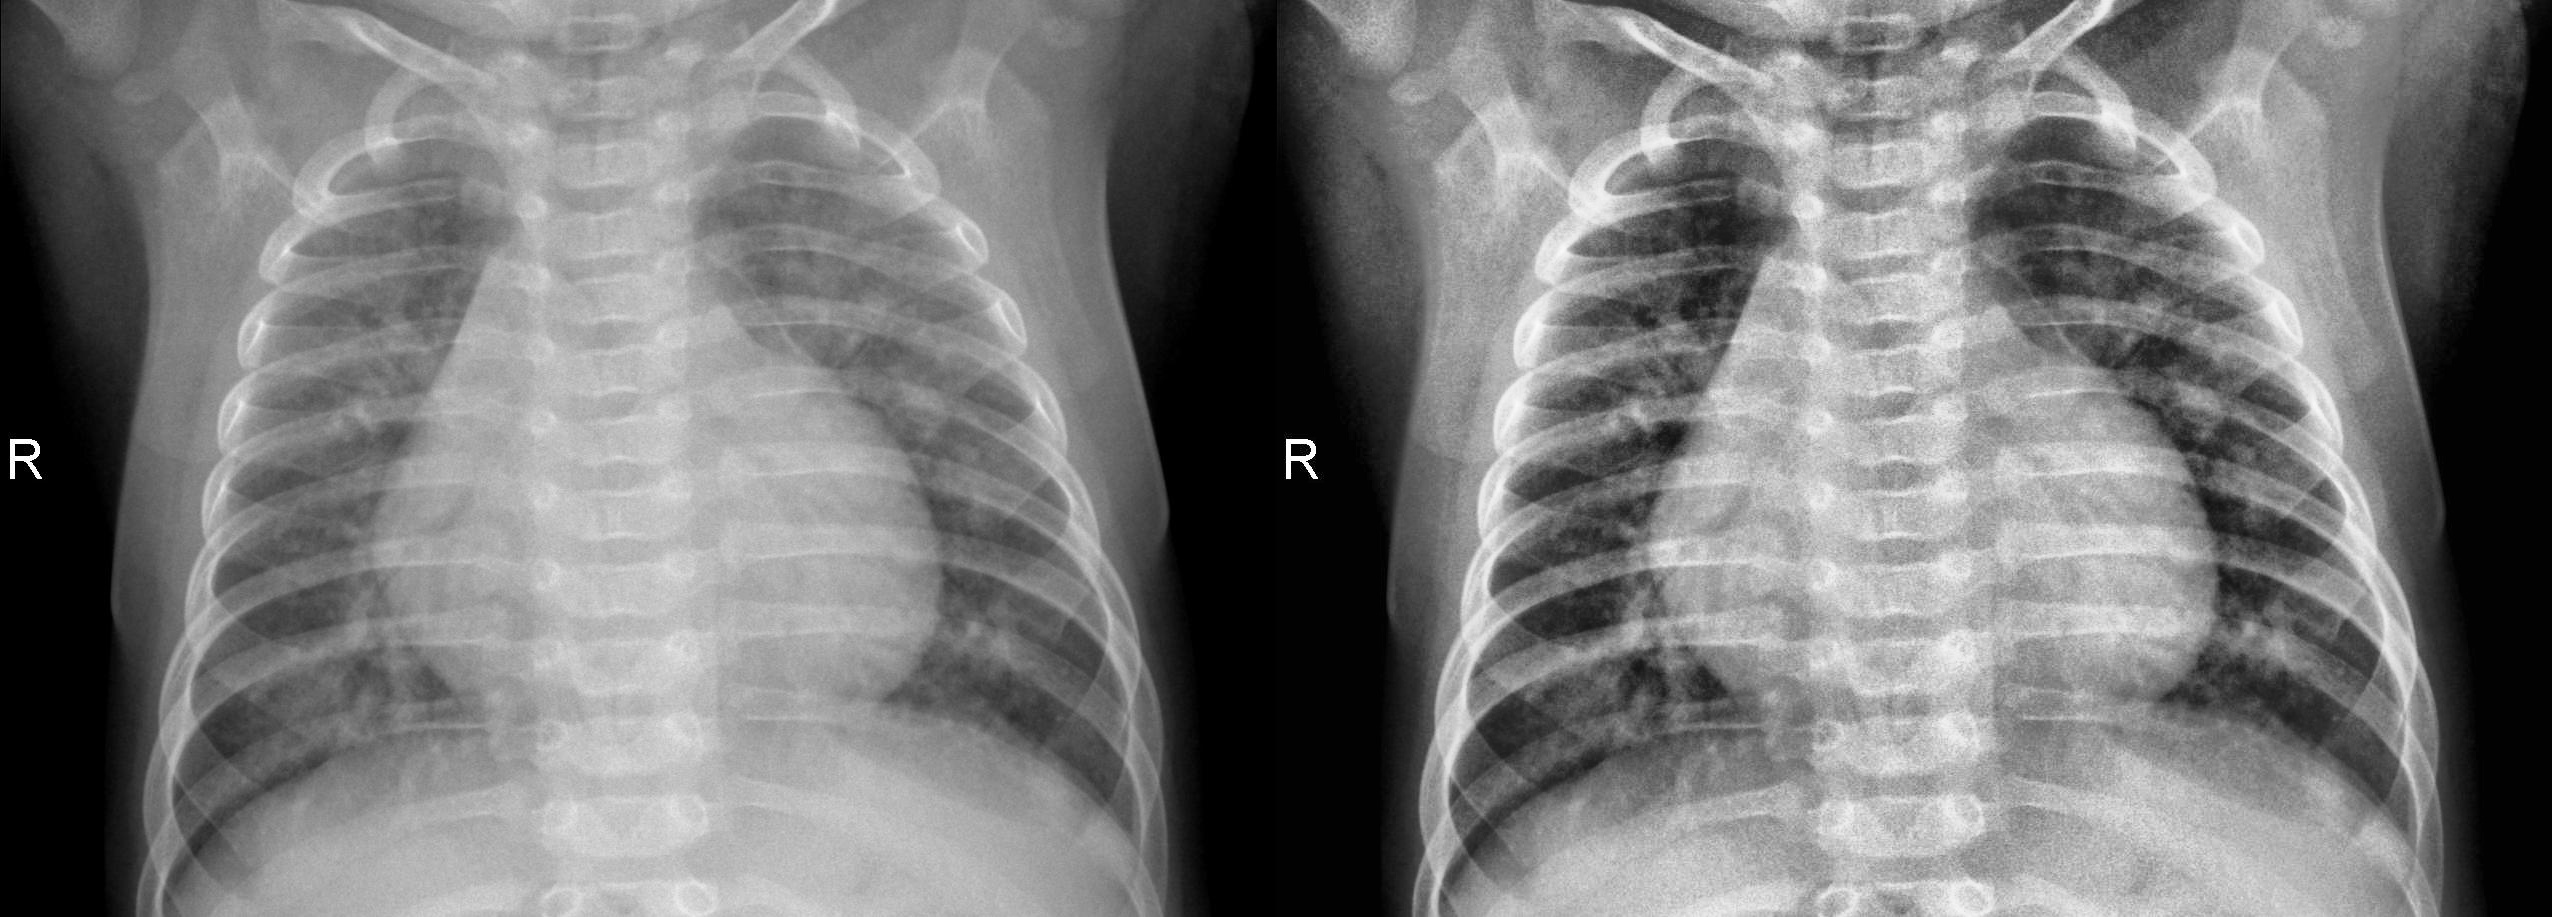

In [32]:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
import cv2
img = cv2.imread('chest_xray/train/PNEUMONIA/BACTERIA-30629-0001.jpeg',0)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
cl1 = clahe.apply(img)
res = np.hstack((img,cl1))
cv2.imwrite('comparison.jpg',res)
load_img('comparison.jpg')

In [33]:
# Create new directories
import os
path = 'chest_xray_contrast'
isExist = os.path.exists(path)

if not isExist:
    os.makedirs(path)

directories = ['train', 'test']
sub_directories = ['NORMAL', 'PNEUMONIA']

if not isExist:
    for directory in directories:
        os.makedirs(path + '/' + directory)
        for sub_directory in sub_directories:
            os.makedirs(path + '/' + directory + '/' + sub_directory)

In [34]:
# Get file paths
if not isExist:
    train_pneumonia_img_files = []
    for file in os.listdir("chest_xray/train/PNEUMONIA/"):
        if file.endswith(".jpeg"):
            train_pneumonia_img_files.append("chest_xray/train/PNEUMONIA/" + os.path.relpath(file))

In [35]:
if not isExist:
    train_pneumonia_imgs_path_contrast = 'chest_xray_contrast/train/PNEUMONIA'

    for img_id, img_path in enumerate(train_pneumonia_img_files):
        img = cv2.imread(img_path, 0)
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{train_pneumonia_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

In [36]:
# Repeat the above for all other images & directories
if not isExist:
    # Get file paths for train NORMAL
    train_norm_img_files = []
    for file in os.listdir("chest_xray/train/NORMAL"):
        if file.endswith(".jpeg"):
            train_norm_img_files.append("chest_xray/train/NORMAL/" + os.path.relpath(file))

    # Get file paths for test PNEUMONIA
    test_pneumonia_img_files = []
    for file in os.listdir("chest_xray/test/PNEUMONIA"):
        if file.endswith(".jpeg"):
            test_pneumonia_img_files.append("chest_xray/test/PNEUMONIA/" + os.path.relpath(file))

    # Get file paths for test NORMAL
    test_norm_img_files = []
    for file in os.listdir("chest_xray/test/NORMAL"):
        if file.endswith(".jpeg"):
            test_norm_img_files.append("chest_xray/test/NORMAL/" + os.path.relpath(file))

In [37]:
if not isExist:
    # Transform train NORMAL images
    train_normal_imgs_path_contrast = 'chest_xray_contrast/train/NORMAL'

    for img_id, img_path in enumerate(train_norm_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{train_normal_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

    # Transform test NORMAL images
    test_normal_imgs_path_contrast = 'chest_xray_contrast/test/NORMAL'

    for img_id, img_path in enumerate(test_norm_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{test_normal_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

    # Transform test PNEUMONIA images
    test_pneumonia_imgs_path_contrast = 'chest_xray_contrast/test/PNEUMONIA'

    for img_id, img_path in enumerate(test_pneumonia_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{test_pneumonia_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

In [38]:
# Contrast Image Directory Path
train_contrast_path = 'chest_xray_contrast/train'
test_contrast_path = 'chest_xray_contrast/test'

In [39]:
train_contrast_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_contrast_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_contrast_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_contrast_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_contrast_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     test_contrast_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [40]:
# Create the data sets
train_contrast_images, train_contrast_labels = next(train_contrast_generator)
test_contrast_images, test_contrast_labels = next(test_contrast_generator)
val_contrast_images, val_contrast_labels = next(val_contrast_generator)

In [41]:
import numpy as np
train_contrast_y = np.reshape(train_contrast_labels[:,0], (4710,1))
test_contras_y = np.reshape(test_contrast_labels[:,0], (624,1))
val_contras_y = np.reshape(val_contrast_labels[:,0], (522,1))

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models

second_cnn_model = models.Sequential()

second_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Flatten())
second_cnn_model.add(layers.Dense(64, activation='relu'))
second_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
second_cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [44]:
# Fit the model
second_cnn_checkpoint_filepath = 'models/second_cnn_model.h5'

# second_cnn_checkpoint_callback = ModelCheckpoint(
#     filepath=second_cnn_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# second_cnn_hist = second_cnn_model.fit(train_contrast_images,
#                     train_contrast_y,
#                     class_weight=class_weights,
#                     epochs=50,
#                     batch_size=32,
#                     callbacks=[second_cnn_checkpoint_callback, reduce_lr],
#                     validation_data=(val_contrast_images, val_contras_y))

Epoch 1/50
148/148 [==============================] - 124s 835ms/step - loss: 0.5073 - acc: 0.7510 - val_loss: 0.7644 - val_acc: 0.3410 - lr: 0.0100
Epoch 2/50
148/148 [==============================] - 123s 833ms/step - loss: 0.3436 - acc: 0.8344 - val_loss: 0.5033 - val_acc: 0.7510 - lr: 0.0100
Epoch 3/50
148/148 [==============================] - 123s 831ms/step - loss: 0.2477 - acc: 0.8943 - val_loss: 0.1866 - val_acc: 0.9349 - lr: 0.0100
Epoch 4/50
148/148 [==============================] - 123s 830ms/step - loss: 0.1847 - acc: 0.9242 - val_loss: 0.2183 - val_acc: 0.9061 - lr: 0.0100
Epoch 5/50
148/148 [==============================] - 123s 831ms/step - loss: 0.1657 - acc: 0.9331 - val_loss: 0.2015 - val_acc: 0.9100 - lr: 0.0100
Epoch 6/50
148/148 [==============================] - 123s 832ms/step - loss: 0.1489 - acc: 0.9378 - val_loss: 0.1449 - val_acc: 0.9483 - lr: 0.0100
Epoch 7/50
148/148 [==============================] - 123s 832ms/step - loss: 0.1344 - acc: 0.9486 - val_l

17/17 [==============================] - 3s 196ms/step


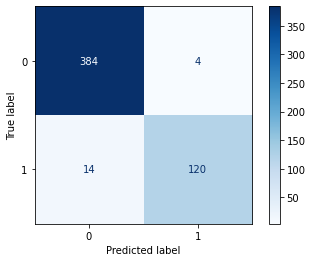

Accuracy: 0.965517
Precision: 0.967742
Recall: 0.895522
F1 score: 0.930233


In [45]:
evaluate_results(second_cnn_model, val_contrast_images, val_contras_y)

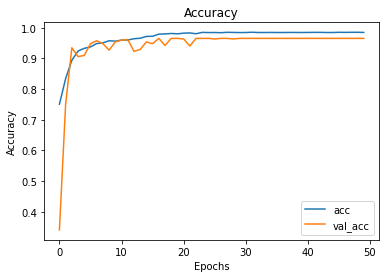

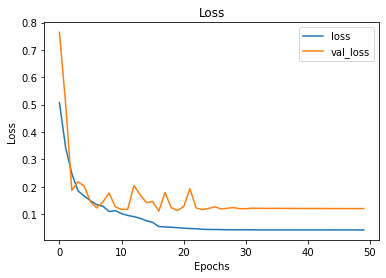

In [46]:
visualize_training_results(second_cnn_hist)

This didn't do as well as the original CNN, but the two CNN models are still the best performing by our F1 Score metric.

Given the amount of research that recommends increasing contrast, we will continue iterating on this image set.

### VGG19

Another frquently utilized model is research is VGG19. 

In [47]:
from tensorflow.keras.applications.vgg19 import VGG19

In [48]:
vgg_model = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')

In [50]:
# Adding layers to model
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout

outputs = vgg_model.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

In [52]:
from keras.layers import Dense, Activation, Flatten
from keras.models import Model
custom_vgg_model = Model(inputs = image_input, outputs=outputs)

for layer in vgg_model.layers:
    layer.trainable = False

custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
# custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])

In [54]:
custom_vgg_checkpoint_filepath = 'models/custom_vgg.h5'

# custom_vgg_checkpoint_callback = ModelCheckpoint(
#     filepath=custom_vgg_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# custom_vgg_hist = custom_vgg_model.fit(train_contrast_images,
#                     train_contrast_labels,
#                     class_weight=class_weights,
#                     batch_size=32,
#                     epochs=24,
#                     callbacks=[custom_vgg_checkpoint_callback, reduce_lr],
#                     validation_data=(val_contrast_images, val_contrast_labels))

Epoch 1/24
148/148 [==============================] - 1643s 11s/step - loss: 0.5184 - acc: 0.8677 - val_loss: 0.1165 - val_acc: 0.9617 - lr: 0.0010
Epoch 2/24
148/148 [==============================] - 1643s 11s/step - loss: 0.2365 - acc: 0.9361 - val_loss: 0.1041 - val_acc: 0.9655 - lr: 0.0010
Epoch 3/24
148/148 [==============================] - 1643s 11s/step - loss: 0.1916 - acc: 0.9495 - val_loss: 0.0936 - val_acc: 0.9713 - lr: 0.0010
Epoch 4/24
148/148 [==============================] - 1643s 11s/step - loss: 0.1513 - acc: 0.9590 - val_loss: 0.0932 - val_acc: 0.9732 - lr: 0.0010
Epoch 5/24
148/148 [==============================] - 1644s 11s/step - loss: 0.1297 - acc: 0.9662 - val_loss: 0.2161 - val_acc: 0.9521 - lr: 0.0010
Epoch 6/24
148/148 [==============================] - 1644s 11s/step - loss: 0.1364 - acc: 0.9662 - val_loss: 0.1365 - val_acc: 0.9636 - lr: 0.0010
Epoch 7/24
148/148 [==============================] - 1643s 11s/step - loss: 0.1172 - acc: 0.9684 - val_loss: 0.

In [58]:
custom_vgg_model = load_model(custom_vgg_checkpoint_filepath)

17/17 [==============================] - 42s 2s/step


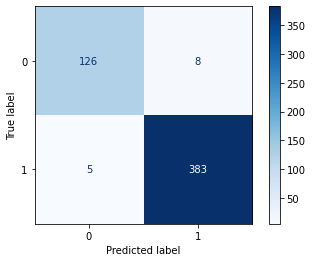

Accuracy: 0.975096
Precision: 0.979540
Recall: 0.987113
F1 score: 0.983312


In [59]:
evaluate_results(custom_vgg_model, val_contrast_images, val_contrast_labels)

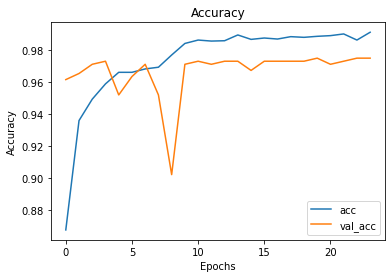

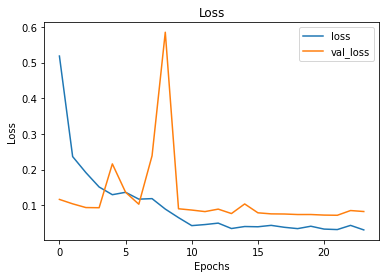

In [60]:
visualize_training_results(custom_vgg_hist)

### Visualizing Intermediate Activations